## Автоматическое дифференцирование

In [126]:
import torch
from torch import autograd

In [127]:
x = torch.arange(4).type(torch.float)
print(x)

tensor([0., 1., 2., 3.])


## Присоединение градиента к `x`

- Говорит системе, что мы хотим хранить градиент

In [132]:
x.requires_grad

True

In [133]:
x = x.requires_grad_()

In [134]:
x.requires_grad

True

In [135]:
x.grad

## Forward

вычислим 

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

In [136]:
y = 2 * x.dot(x)

In [137]:
print(y)

tensor(28., grad_fn=<MulBackward0>)


In [138]:
print(x)
print(x.grad)

tensor([0., 1., 2., 3.], requires_grad=True)
None


## Backward

In [139]:
y.backward()

In [140]:
print(x)
print(x.grad)

tensor([0., 1., 2., 3.], requires_grad=True)
tensor([ 0.,  4.,  8., 12.])


## Получение градиента

$y = 2\mathbf{x}^{\top}\mathbf{x}$, значит 

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Проверим:

In [78]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [79]:
4 * x == x.grad

tensor([True, True, True, True])

## no_grad

функция no_grad позволяет отключить вычисление градиента для части кода

In [80]:
y = 2 * x.dot(x)
print(y.grad_fn)
with torch.no_grad():
    y = 2 * x.dot(x)
    print(y.grad_fn)

None


In [81]:
y = 2 * x.dot(x)
y.backward()
print(x.grad)
with torch.no_grad():
    y = 2 * x.dot(x)
    y.backward()
    print(x.grad)

tensor([ 0.,  8., 16., 24.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Гибкий граф

In [54]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [55]:
a = torch.randn(1).requires_grad_()
d = f(a)
d.backward()

In [56]:
d

tensor([-113326.4141], grad_fn=<MulBackward0>)

In [57]:
a.grad

tensor([409600.])

## Практика

1. Пусть $f(x) = \sin(x) * x$. Постройте график $f(x)$ и $\frac{df(x)}{dx}$ используя пакет autograd'а для расчета производных (т.е. нельзя выводить производную явно)

In [58]:
def f(x):
    return torch.sin(x) * x

In [87]:
x = torch.arange(4).type(torch.float)
x = x.requires_grad_()
print(x)

tensor([0., 1., 2., 3.], requires_grad=True)


In [171]:
axis = []
output = []
diffs = []

for i in torch.arange(-5., 5., 0.01):
    axis.append(i.item())
    i.requires_grad_()
    y = f(i)
    output.append(y.item())
    y.backward()
    diffs.append(i.grad.item())

In [172]:
import matplotlib.pyplot as plt

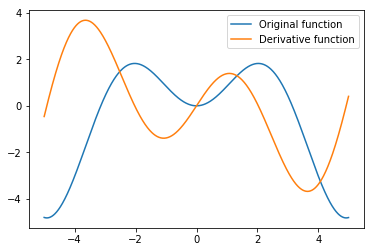

In [178]:
plt.plot(axis, output, label = 'Original function')
plt.plot(axis, diffs, label = 'Derivative function')
plt.legend()
plt.show()

## Линейная регрессия с нуля

In [103]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Генерируем данные

- Случайно генерируем $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Выбираем значения весов (истинные): $\mathbf{w} = [2, -3.4]^\top$ и свободного члена $b = 4.2$
- Генерируем метки по формле $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  с шумом $\epsilon$ нормально распределнным с мат ожиданием 0 и дисперсией 1

In [104]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

## Визуализируем данные

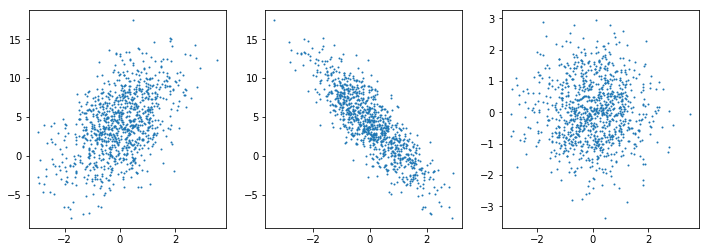

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(features[:, 0], labels, 1)
plt.subplot(132)
plt.scatter(features[:, 1], labels, 1)
plt.subplot(133)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.show()

## Чтение данных

Итерируемся по датасету и возвращаем случаные `batch_size` примеров.

In [22]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # число 100
    indices = list(range(num_examples)) # список чисел от 0 до 99
    # The examples are read at random, in no particular order
    random.shuffle(indices) # перемешиваем этот список
    for i in range(0, num_examples, batch_size): 
        j = indices[i: min(i + batch_size, num_examples)] # Выбираем индексы для батчка
        yield features[j, :], labels[j] # возвращаем батч

## Выводим маленький батч

In [23]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.7696, -0.2004],
        [-0.9723,  0.9377],
        [-0.7914, -1.7629],
        [-0.0597, -0.4353],
        [ 0.4189,  0.5593],
        [ 0.5996,  1.5973],
        [ 0.5592,  1.0066],
        [-0.6111, -1.0566],
        [-0.6540,  1.4203],
        [ 1.1008, -0.7073]]) tensor([ 3.8773,  0.6959,  7.3161,  6.6675,  3.6379,  0.4875,  1.0596,  6.6958,
        -2.6231,  9.1001])


### Создаем нашу модель для обучения

In [24]:
w = torch.randn((num_inputs))
b = torch.zeros((1,))

In [25]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

In [26]:
def linreg(X, w, b):
    return torch.mv(X, w) + b

### Обучение

In [27]:
def squared_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2).mean()

In [28]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [29]:
lr = 0.01  
num_epochs = 20

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()
        
        l = squared_loss(linreg(X, w, b), y)
        l.backward()
        sgd([w, b], lr)

    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 1.765860
epoch 2, loss 1.035416
epoch 3, loss 1.014329
epoch 4, loss 1.015822
epoch 5, loss 1.014500
epoch 6, loss 1.013927
epoch 7, loss 1.013696
epoch 8, loss 1.013904
epoch 9, loss 1.013829
epoch 10, loss 1.014096
epoch 11, loss 1.014064
epoch 12, loss 1.014437
epoch 13, loss 1.015409
epoch 14, loss 1.013920
epoch 15, loss 1.015775
epoch 16, loss 1.015373
epoch 17, loss 1.013739
epoch 18, loss 1.014939
epoch 19, loss 1.013751
epoch 20, loss 1.016416


## Оценка качества модели

In [30]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w tensor([0.0615, 0.0857], grad_fn=<SubBackward0>)
Error in estimating b tensor([-0.0917], grad_fn=<RsubBackward1>)
tensor([ 1.9385, -3.4857], grad_fn=<CopySlices>)
tensor([4.2917], grad_fn=<CopySlices>)


## Линейная регрессия на torch

In [31]:
from torch.utils.data import TensorDataset, DataLoader

In [32]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

In [33]:
batch_size = 10
dataset = TensorDataset(features, labels)
# Randomly reading mini-batches
data_iter = DataLoader(dataset, batch_size, shuffle=True)

# Read a batch to see how it works
for X, y in data_iter:
    print(X, y)
    break

tensor([[-0.2465, -0.8683],
        [-0.1051, -0.0890],
        [-0.9026, -0.8632],
        [ 0.1963, -1.8687],
        [ 1.1093,  0.5232],
        [ 0.0320, -1.3907],
        [-0.5454,  0.0350],
        [ 0.9899, -0.0763],
        [-0.4574,  0.7149],
        [ 0.9456,  1.3655]]) tensor([7.5588, 4.5192, 3.5462, 9.9342, 4.6377, 7.9941, 3.6175, 5.6314, 0.4401,
        1.6064])


In [34]:
model = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [35]:
loss = torch.nn.MSELoss(reduction='mean')

In [36]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [37]:
num_epochs = 20
for epoch in range(0, num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model.forward(X).reshape(-1), y)
        l.backward()
        trainer.step()
    l = loss(model.forward(features).reshape(-1), labels)
    print('epoch %d, loss: %f' % (epoch, l.item()))
    print('w', model[0].weight.data)
    print('b', model[0].bias.data)

epoch 0, loss: 27.112528
w tensor([[ 0.0788, -0.4635]])
b tensor([0.4305])
epoch 1, loss: 18.716101
w tensor([[ 0.4377, -0.9927]])
b tensor([1.0858])
epoch 2, loss: 13.029295
w tensor([[ 0.7304, -1.4258]])
b tensor([1.6279])
epoch 3, loss: 9.172315
w tensor([[ 0.9699, -1.7806]])
b tensor([2.0771])
epoch 4, loss: 6.556776
w tensor([[ 1.1658, -2.0728]])
b tensor([2.4476])
epoch 5, loss: 4.783646
w tensor([[ 1.3256, -2.3122]])
b tensor([2.7543])
epoch 6, loss: 3.580016
w tensor([[ 1.4564, -2.5089]])
b tensor([3.0082])
epoch 7, loss: 2.765373
w tensor([[ 1.5632, -2.6700]])
b tensor([3.2177])
epoch 8, loss: 2.212463
w tensor([[ 1.6510, -2.8028]])
b tensor([3.3905])
epoch 9, loss: 1.838034
w tensor([[ 1.7219, -2.9117]])
b tensor([3.5333])
epoch 10, loss: 1.583452
w tensor([[ 1.7797, -3.0013]])
b tensor([3.6518])
epoch 11, loss: 1.410486
w tensor([[ 1.8272, -3.0749]])
b tensor([3.7499])
epoch 12, loss: 1.292856
w tensor([[ 1.8667, -3.1357]])
b tensor([3.8309])
epoch 13, loss: 1.213888
w tenso

In [38]:
w = model[0].weight.data
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b', true_b - b)

Error in estimating w tensor([[ 0.0022, -0.0578]])
Error in estimating b tensor([0.0851])


In [39]:
model[0].weight.data

tensor([[ 1.9978, -3.3422]])

In [40]:
model[0].bias.data

tensor([4.1149])

## Научимся отличать рукописные цифры

In [105]:
import torchvision
import time

In [106]:
def transform(data):
    data = torch.tensor(data.getdata(), dtype=torch.float32)
    return torch.floor(data / 128.).squeeze(axis=-1)

In [107]:
mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
mnist_test  = torchvision.datasets.MNIST('.', train=False, transform=transform, download=True)


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [179]:
mnist_train[0][0].shape

torch.Size([784])

In [113]:
model = torch.nn.Sequential(torch.nn.Linear(784, 10))
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [114]:
train, test = torch.utils.data.DataLoader(mnist_train, 256, shuffle=True), torch.utils.data.DataLoader(mnist_test, 256)

In [115]:
num_epochs = 10
for epoch in range(0, num_epochs):
    start, train_loss, train_acc, train_n, test_loss, test_acc, test_n = time.time(), 0., 0., 0, 0., 0., 0
    
    # режим обучения
    model.train()
    for X, y in train:
        trainer.zero_grad() # не забывать обнуление градента!
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        # y_hat.argmax(dim=1) - номер класса, который предсказала модель 
        train_acc += (y_hat.argmax(dim=1) == y).sum().item()
        train_n += len(X)
    
    # режим вычисления
    model.eval()
    for X, y in test:
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        test_loss += l.item()
        test_acc += (y_hat.argmax(dim=1) == y).sum().item()
        test_n += len(X)   
        
    print("""epoch {}, taked: {:.3f}
train -> loss: {:.3f}, acc: {:.3f}
test -> loss: {:.3f}, acc: {:.3f}
""".format(epoch, time.time() - start, train_loss / train_n, train_acc / train_n,
       test_loss / test_n, test_acc / test_n))


epoch 0, taked: 11.825
train -> loss: 0.536, acc: 0.862
test -> loss: 0.365, acc: 0.901

epoch 1, taked: 14.836
train -> loss: 0.365, acc: 0.898
test -> loss: 0.334, acc: 0.909

epoch 2, taked: 16.189
train -> loss: 0.338, acc: 0.906
test -> loss: 0.317, acc: 0.912

epoch 3, taked: 16.058
train -> loss: 0.323, acc: 0.909
test -> loss: 0.309, acc: 0.913

epoch 4, taked: 15.854
train -> loss: 0.314, acc: 0.912
test -> loss: 0.303, acc: 0.915

epoch 5, taked: 15.704
train -> loss: 0.308, acc: 0.914
test -> loss: 0.301, acc: 0.916

epoch 6, taked: 15.793
train -> loss: 0.302, acc: 0.916
test -> loss: 0.299, acc: 0.915

epoch 7, taked: 15.832
train -> loss: 0.298, acc: 0.916
test -> loss: 0.296, acc: 0.916

epoch 8, taked: 15.711
train -> loss: 0.295, acc: 0.917
test -> loss: 0.293, acc: 0.919

epoch 9, taked: 16.096
train -> loss: 0.292, acc: 0.918
test -> loss: 0.292, acc: 0.918

